# Environment

In [1]:
import torch
from random import randint
import pytorch_lightning as pl
from IPython.display import Audio
from helpers.path_utils import get_base_dir
from model import CoraTechDataset, CoraTechModel
from helpers.plot import compare_audios, plot_wavelet_spectrogram, plot_audio_fft, plot_model_result

CHUNK_SECS = 2
TENSORS_DIR = get_base_dir().joinpath("data", "model", "train")
sample_rate = 4000

# Instance Dataset

In [2]:
cora_dataset = CoraTechDataset(TENSORS_DIR, CHUNK_SECS)
n_samples = len(cora_dataset)

print(f"Number of samples: {n_samples}")

Number of samples: 115


# Compare heartbeats

#88 / 115
mobile shape, mean and std:  torch.Size([1, 8000]) tensor(8.2841e-06) tensor(1.)
stethos shape, mean and std:  torch.Size([1, 8000]) tensor(-2.5749e-06) tensor(1.)


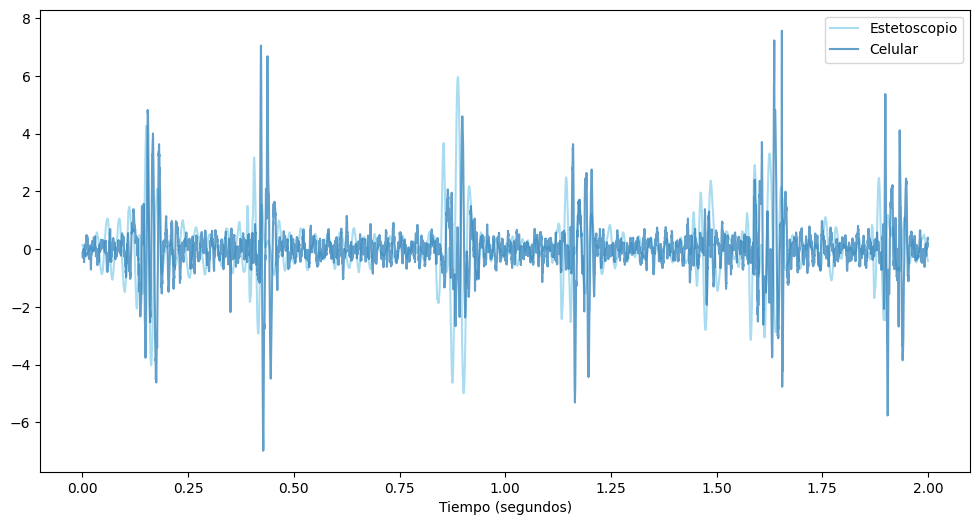

In [3]:
choosen_one = randint(0, n_samples)
print(f"#{choosen_one} / {n_samples}")

mobile_sample, stethos_sample = cora_dataset[choosen_one]

print(
    "mobile shape, mean and std: ",
    mobile_sample.shape,
    mobile_sample.mean(),
    mobile_sample.std(),
)
print(
    "stethos shape, mean and std: ",
    stethos_sample.shape,
    stethos_sample.mean(),
    stethos_sample.std(),
)

compare_audios(mobile_sample.squeeze(), stethos_sample.squeeze(), sample_rate)

## Mobile recording

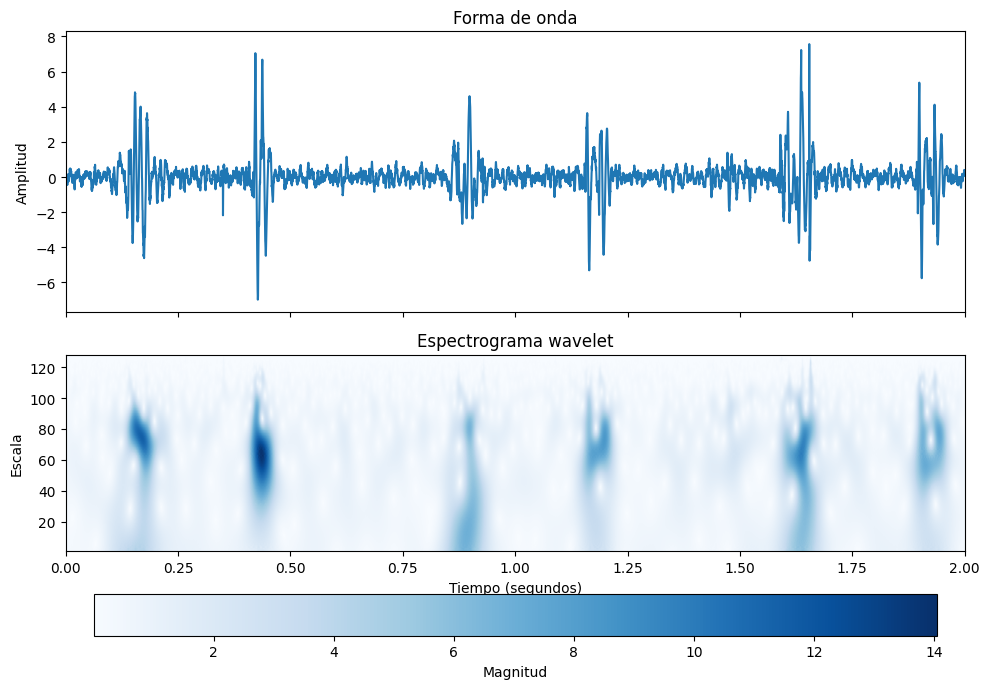

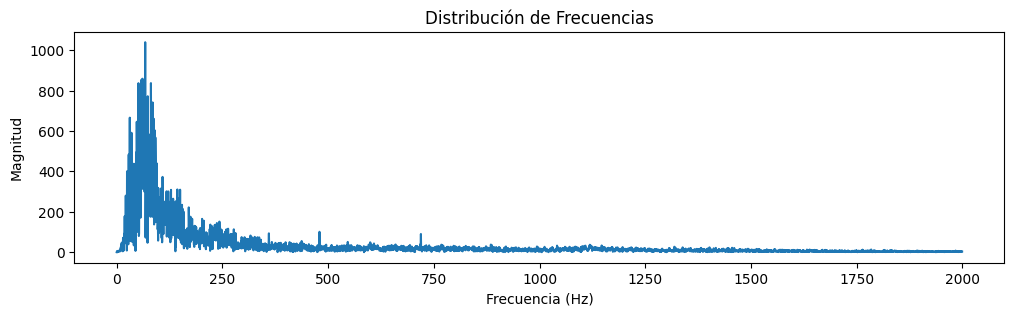

In [4]:
plot_wavelet_spectrogram(mobile_sample.numpy(), sample_rate, downsample_factor=1)
plot_audio_fft(mobile_sample.numpy(), sample_rate)
Audio(mobile_sample, rate=sample_rate, autoplay=True)

## Stethoscope recording

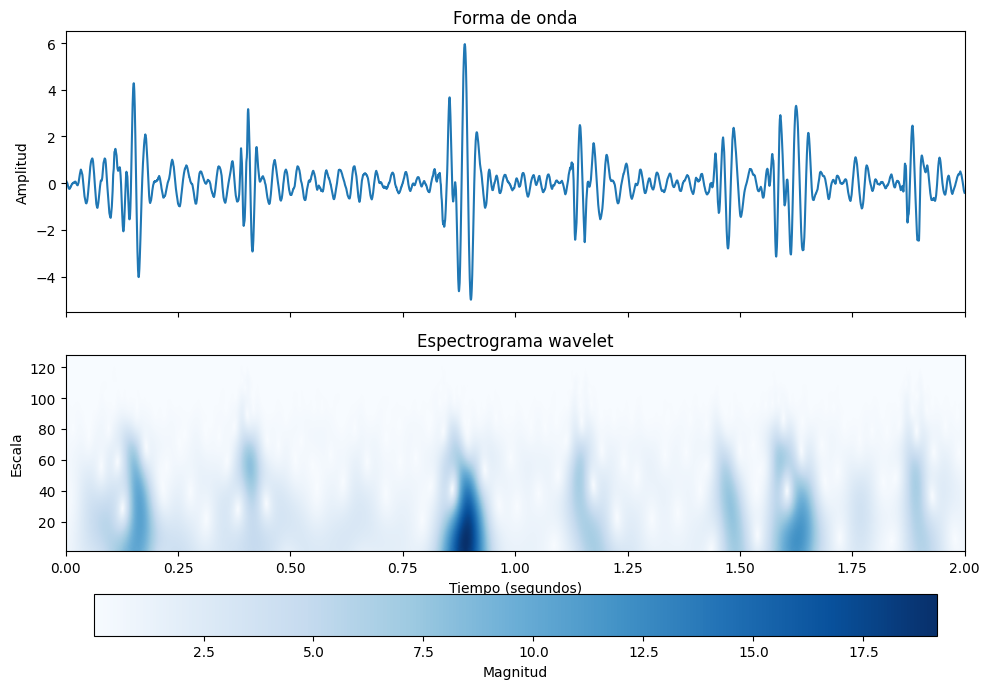

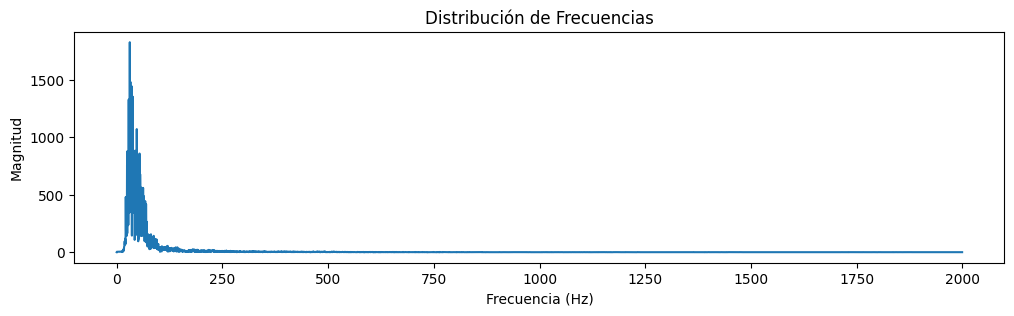

In [5]:
plot_wavelet_spectrogram(stethos_sample.numpy(), sample_rate, downsample_factor=1)
plot_audio_fft(stethos_sample.numpy(), sample_rate)
Audio(stethos_sample, rate=sample_rate, autoplay=True)

# Train, validation and test split

In [6]:
batch_size = 50
train_ratio = 0.7
val_ratio = 0.15

train_size = int(train_ratio * len(cora_dataset))
val_size = int(val_ratio * len(cora_dataset))
test_size = len(cora_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    cora_dataset, [train_size, val_size, test_size]
)

train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
)
val_dataloader = torch.utils.data.DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False,
)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False)

# Callbacks

In [7]:
checkpoint = pl.callbacks.ModelCheckpoint(
    monitor="val_loss",
    dirpath="checkpoints/",
    filename="autoencoder-{epoch:02d}-{val_loss:.4f}",
    save_top_k=1,
    mode="min",
)

early_stopping = pl.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")

lr_monitor = pl.callbacks.LearningRateMonitor(logging_interval="epoch")

callbacks = [checkpoint, early_stopping, lr_monitor]

# Train!

In [8]:
model = CoraTechModel(input_size=cora_dataset[0][0].shape[-1])

logger = pl.loggers.tensorboard.TensorBoardLogger("logs/", name="coratech_model")

trainer = pl.Trainer(max_epochs=500, callbacks=callbacks, logger=logger)
# trainer.fit(model, train_dataloader, val_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


# Predict

## Best model

In [9]:
# # code to fetch the lowest val_loss

# from pathlib import Path
# import re

# directory = Path('path/to/your/folder')
# pattern = r'autonencoder-epoch-\d+-val_loss=([\d\.]+)\.ckpt'
# val_loss_values = {}

# for file_path in directory.iterdir():
#     if file_path.is_file():
#         match = re.match(pattern, file_path.name)
#         if match:
#             val_loss = float(match.group(1))
#             val_loss_values[file_path] = val_loss

# if val_loss_values:
#     best_file = min(val_loss_values, key=val_loss_values.get)
#     print(f"The file with the lowest validation loss is: {best_file.name} with a loss of {val_loss_values[best_file]}")
# else:
#     print("No files matching the specified pattern were found.")

In [10]:
model_to_pred = CoraTechModel(input_size=cora_dataset[0][0].shape[-1])
model_dir = r'checkpoints\autoencoder-epoch=00-val_loss=1.0023.ckpt'

model_to_pred.load_state_dict(torch.load(model_dir)['state_dict'])
model_to_pred.eval()

CoraTechModel(
  (lstm1): LSTM(8000, 2048, batch_first=True)
  (lstm2): LSTM(2048, 2048, batch_first=True)
  (dense1): Linear(in_features=2048, out_features=2048, bias=True)
  (dense2): Linear(in_features=2048, out_features=1024, bias=True)
  (dense3): Linear(in_features=1024, out_features=1024, bias=True)
  (output_layer): Linear(in_features=1024, out_features=8000, bias=True)
)

# Loss in validation set

In [11]:
total_loss = 0.0
num_samples = 0

with torch.no_grad():
    for batch in test_dataloader:
        inputs, targets = batch
        predictions = model(inputs)
        batch_loss = torch.nn.MSELoss()(predictions, targets)
        total_loss += batch_loss.item()
        num_samples += len(inputs)

mse_loss = total_loss / num_samples
print(f'MSE Loss in test set: {mse_loss:.4f}')

MSE Loss en el conjunto de prueba: 0.0556


# Result!

#1


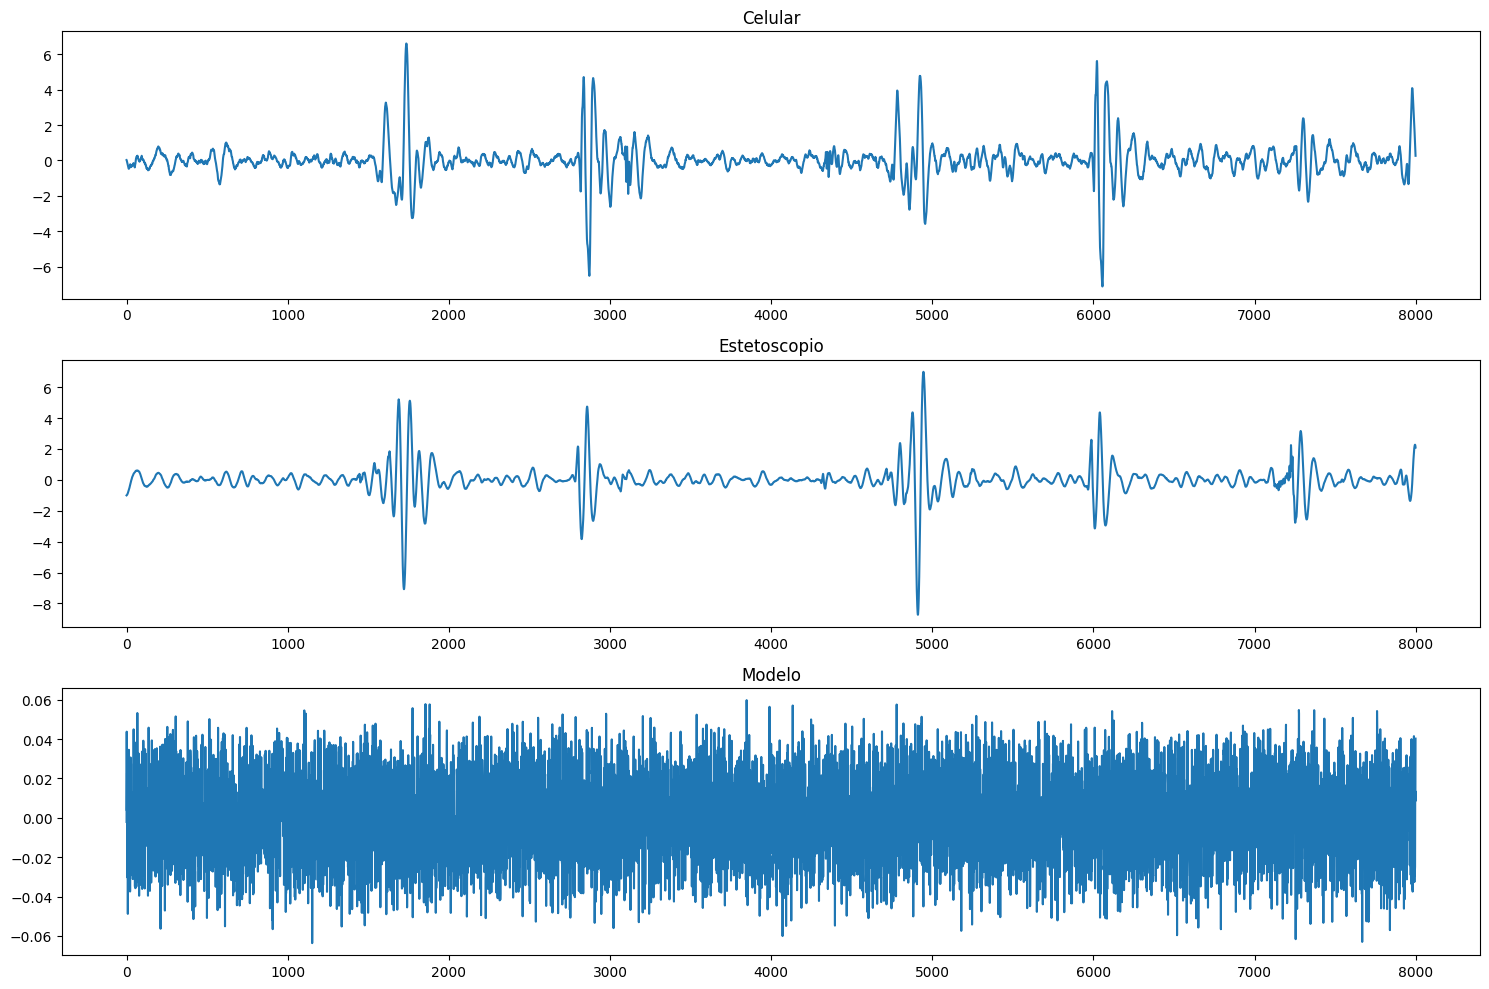

In [12]:
choosen_one_pred = randint(0, len(test_dataloader))

print(f"#{choosen_one_pred}")

model_result = plot_model_result(model, test_dataloader, choosen_one_pred)